In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv('train.csv')
train_df.head(5)

,id,feedback_text,toxic,abusive,vulgar,menace,offense,bigotry
0,281d77b7bebc2201,:::Sounds good. Let me know when you're done ...,0,0,0,0,0,0
1,716aac7bf3c63db1,"""\nI say something, but it didn't actually con...",0,0,0,0,0,0
2,57cb318c6edcf10c,"""Agustina Barrientos]] \n | Modelo de Piñeiro ...",0,0,0,0,0,0
3,dc3bd70118d91b3a,FYI I enjoy licking strangers scrotal sacks......,1,0,1,0,0,0
4,cf10d41f2997d233,How do you get a site?\nMany penguins have ask...,0,0,0,0,0,0


In [3]:
train_df.shape

(23473, 8)

In [4]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23473 entries, 0 to 23472
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             23473 non-null  object
 1   feedback_text  23473 non-null  object
 2   toxic          23473 non-null  int64 
 3   abusive        23473 non-null  int64 
 4   vulgar         23473 non-null  int64 
 5   menace         23473 non-null  int64 
 6   offense        23473 non-null  int64 
 7   bigotry        23473 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 1.4+ MB


In [5]:
train_df['label_count'] = train_df[['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']].sum(axis=1)
train_df['label_count']

0        0
1        0
2        0
3        2
4        0
        ..
23468    2
23469    2
23470    0
23471    0
23472    2
Name: label_count, Length: 23473, dtype: int64

In [6]:
train_df['text_length'] = train_df['feedback_text'].apply(lambda x: len(str(x.strip())))
train_df['text_length']

0          68
1         413
2         173
3          73
4         432
         ... 
23468      26
23469      20
23470     251
23471    2782
23472     135
Name: text_length, Length: 23473, dtype: int64

In [7]:
label_columns = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']
label_counts = train_df[label_columns].sum().sort_values(ascending=True)
label_counts

menace       66
abusive     176
bigotry     193
offense    1150
vulgar     1275
toxic      2196
dtype: int64

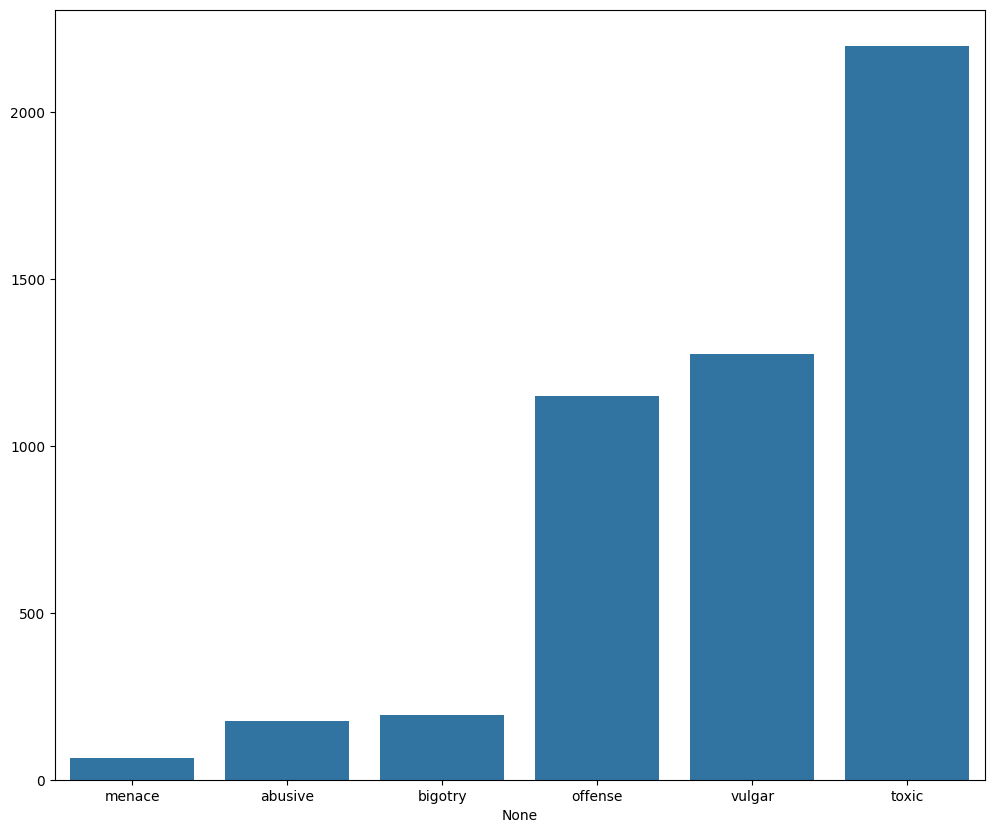

In [8]:
plt.figure(figsize=(12,10))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.show()

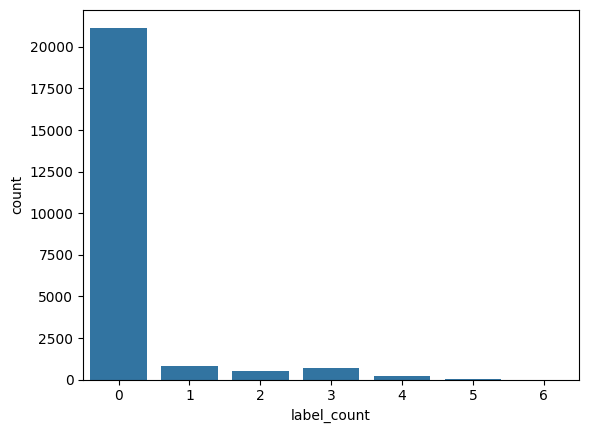

In [9]:
sns.countplot(data=train_df, x='label_count')
plt.show()

<Axes: xlabel='text_length', ylabel='Count'>

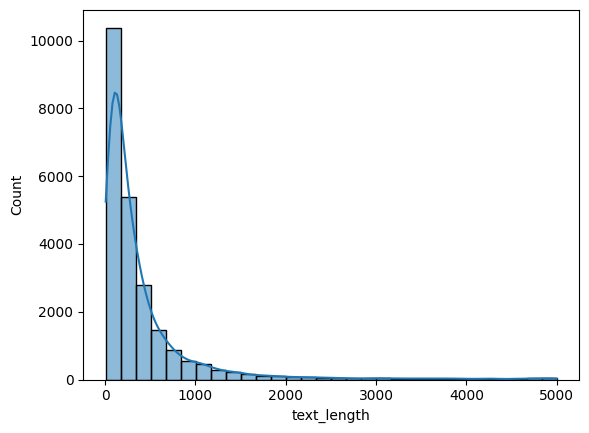

In [10]:
sns.histplot(train_df['text_length'], bins=30, kde=True)

In [11]:
null_count = train_df['feedback_text'].isnull().sum()
empty_comments = train_df['feedback_text'].apply(lambda x: str(x).strip == '').sum()
print(null_count, empty_comments)

0 0


In [12]:
train_df.groupby('toxic')['text_length'].mean()

toxic
0    415.840673
1    268.198087
Name: text_length, dtype: float64

In [13]:
train_df[train_df['toxic'] == 1]['feedback_text'].head()

3     FYI I enjoy licking strangers scrotal sacks......
7                                GO GET A IFE DICK SHOW
11    "\n\n""Failed""? Those images fully comply wit...
12    Fucking lying nigger, fes up you peice of shit...
13    Don't hide the incriminating photographs you N...
Name: feedback_text, dtype: object

<Axes: >

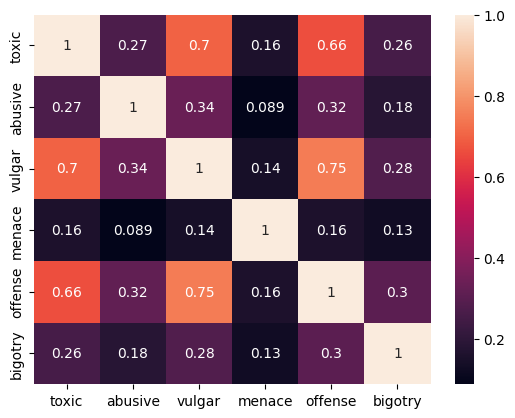

In [14]:
sns.heatmap(train_df[label_columns].corr(), annot=True)

In [15]:
train_df.head(2)

,id,feedback_text,toxic,abusive,vulgar,menace,offense,bigotry,label_count,text_length
0,281d77b7bebc2201,:::Sounds good. Let me know when you're done ...,0,0,0,0,0,0,0,68
1,716aac7bf3c63db1,"""\nI say something, but it didn't actually con...",0,0,0,0,0,0,0,413


In [16]:
validation_df = pd.read_csv('validation.csv')
validation_df.head(2)

,id,feedback_text,lang,toxic
0,1203,İyi tamam olabilir. Balkanlar maddesini gelişt...,tr,0
1,5871,"Por dios, y la canción de John Lennon: http://...",es,1


In [17]:
validation_df['lang'].unique()

array(['tr', 'es', 'it'], dtype=object)

In [18]:
validation_df['lang'].value_counts()

lang
tr    299
es    279
it    262
Name: count, dtype: int64

In [19]:
test_df = pd.read_csv('test.csv')
test_df.head(2)

,id,content,lang
0,56496,"Bahar merhaba, Şu TV programı için bildiğin gi...",tr
1,18266,"Merhaba, başlık taşıma nedeniyle bir karışıklı...",tr


In [20]:
test_df['lang'].unique()

array(['tr', 'fr', 'pt', 'it', 'ru', 'es'], dtype=object)

In [21]:
test_df['lang'].value_counts()

lang
tr    1449
ru    1182
pt    1167
fr    1149
it     904
es     849
Name: count, dtype: int64

In [22]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


In [23]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/afrin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/afrin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/afrin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

- Detects the language using langdetect
- calculates the ratio of characters
- punctuation checks
- low alphabetic check
- translate to english
- filtering out the meaningless, normalization and language translation

In [24]:
from langdetect import detect, DetectorFactory
from googletrans import Translator

DetectorFactory.seed = 0  
translator = Translator()

def detect_language_safe(text):
    try:
        return detect(text)
    except Exception:
        return 'unknown'

def char_ratio(text):
    text = str(text)
    return sum(c.isalpha() for c in text) / len(text) if len(text) > 0 else 0

def is_punct_only(text):
    return all(char in string.punctuation for char in str(text).strip())

def is_low_alpha(text):
    tokens = nltk.word_tokenize(text)
    return all(not any(c.isalpha() for c in token) for token in tokens)

def translate_to_english(text):
    try:
        return translator.translate(text, dest='en').text
    except Exception:
        return text 

- detect language
- filter all the noise like short texts, punctuation, low alphabet
- stopword remove
- lemmatization

In [25]:
def preprocess_with_lang(df, col='feedback_text', detect_lang=False):
    
    df = df.copy()
    lemmatizer = WordNetLemmatizer()
    punctuation_wo_apostrophe = string.punctuation.replace("'", "")
    
    multilingual_stopwords = {
        'en': set(stopwords.words('english')),
        'es': set(stopwords.words('spanish')),
        'tr': set(stopwords.words('turkish')),
        'fr': set(stopwords.words('french')),
        'pt': set(stopwords.words('portuguese')),
        'it': set(stopwords.words('italian')),
        'de': set(stopwords.words('german')),
        'ru': set(stopwords.words('russian')),
    }
    
   
    if detect_lang or 'lang' not in df.columns:
        df['lang'] = df[col].apply(detect_language_safe)
    
   
    df['alpha_ratio'] = df[col].apply(char_ratio)
    df['text_length'] = df[col].str.split().apply(len)
    df['is_punct'] = df[col].apply(is_punct_only)
    df['is_low_alpha'] = df[col].apply(is_low_alpha)
    
    df = df[df['text_length'] >= 3]
    df = df[df['alpha_ratio'] > 0.4]
    df = df[~df['is_punct']]
    df = df[~df['is_low_alpha']]
    
    def clean_text(text, lang):
        stop_words = multilingual_stopwords.get(lang, set())
        text = str(text).lower()
        text = re.sub(r'[\n\r]+', ' ', text)
        text = re.sub(r'\d+', '', text)
        text = re.sub(rf"[{re.escape(punctuation_wo_apostrophe)}]", '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        tokens = nltk.word_tokenize(text)
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        return ' '.join(tokens)
    
   
    df['clean_text'] = df.apply(lambda row: clean_text(row[col], row['lang']), axis=1)
    df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))
    
    label_cols = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']
    if all(col in df.columns for col in label_cols):
        df['label_count'] = df[label_cols].sum(axis=1)
    
    return df

In [26]:
train_df = preprocess_with_lang(train_df, col='feedback_text', detect_lang=True)

In [27]:
train_df.head(5)

,id,feedback_text,toxic,abusive,vulgar,menace,offense,bigotry,label_count,text_length,lang,alpha_ratio,is_punct,is_low_alpha,clean_text
0,281d77b7bebc2201,:::Sounds good. Let me know when you're done ...,0,0,0,0,0,0,0,9,en,0.705882,False,False,sound good let know 're done 'll start pr
1,716aac7bf3c63db1,"""\nI say something, but it didn't actually con...",0,0,0,0,0,0,0,42,en,0.745763,False,False,say something n't actually confirm anything pu...
2,57cb318c6edcf10c,"""Agustina Barrientos]] \n | Modelo de Piñeiro ...",0,0,0,0,0,0,0,11,es,0.578035,False,False,agustina barrientos modelo piñeiro juán cruz a...
3,dc3bd70118d91b3a,FYI I enjoy licking strangers scrotal sacks......,1,0,1,0,0,0,2,9,en,0.808219,False,False,fyi enjoy licking stranger scrotal sacksespeci...
4,cf10d41f2997d233,How do you get a site?\nMany penguins have ask...,0,0,0,0,0,0,0,35,en,0.750000,False,False,get site many penguin asked question simple go...


In [28]:
train_df['lang'].unique()

array(['en', 'es', 'tl', 'no', 'fa', 'af', 'de', 'id', 'so', 'fr', 'vi',
       'sl', 'pt', 'sw', 'hr', 'et', 'da', 'nl', 'it', 'cs', 'sv', 'tr',
       'ro', 'cy', 'ar', 'fi', 'pl', 'bn', 'ca', 'hu', 'sq', 'ru', 'he',
       'ko', 'zh-cn', 'gu', 'ta', 'el', 'sk', 'unknown', 'hi', 'th', 'mk',
       'ml', 'zh-tw', 'lt', 'te', 'mr', 'bg'], dtype=object)

In [29]:
train_df['lang'].value_counts()

lang
en         22531
de            85
fr            58
so            56
af            49
id            43
no            33
et            33
tl            28
es            27
nl            27
cy            27
sv            26
pt            25
ca            21
da            20
tr            20
it            20
hr            19
ro            18
vi            16
fa            14
ar            12
sq            11
hu            10
pl             7
sl             7
sw             6
ru             6
fi             6
el             3
hi             3
sk             3
he             2
bn             2
cs             2
ko             2
unknown        2
ml             2
zh-cn          1
ta             1
gu             1
th             1
mk             1
zh-tw          1
lt             1
te             1
mr             1
bg             1
Name: count, dtype: int64

In [30]:
train_df['translated_text'] = train_df['clean_text'].apply(translate_to_english)
train_df.head(2)

/tmp/ipykernel_160438/2260654159.py:28: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  return text


,id,feedback_text,toxic,abusive,vulgar,menace,offense,bigotry,label_count,text_length,lang,alpha_ratio,is_punct,is_low_alpha,clean_text,translated_text
0,281d77b7bebc2201,:::Sounds good. Let me know when you're done ...,0,0,0,0,0,0,0,9,en,0.705882,False,False,sound good let know 're done 'll start pr,sound good let know 're done 'll start pr
1,716aac7bf3c63db1,"""\nI say something, but it didn't actually con...",0,0,0,0,0,0,0,42,en,0.745763,False,False,say something n't actually confirm anything pu...,say something n't actually confirm anything pu...


- clean input for model evaluation
- language noise removed during feature engineering

In [31]:
validation_df = preprocess_with_lang(validation_df, col='feedback_text', detect_lang=False)
test_df = preprocess_with_lang(test_df, col='content', detect_lang=False)

validation_df['translated_text'] = validation_df['clean_text'].apply(translate_to_english)
test_df['translated_text'] = test_df['clean_text'].apply(translate_to_english)

/tmp/ipykernel_160438/2260654159.py:28: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  return text
/tmp/ipykernel_160438/2260654159.py:28: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  return text


/tmp/ipykernel_160438/1892309529.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_sums.index, y=label_sums.values, palette='magma')


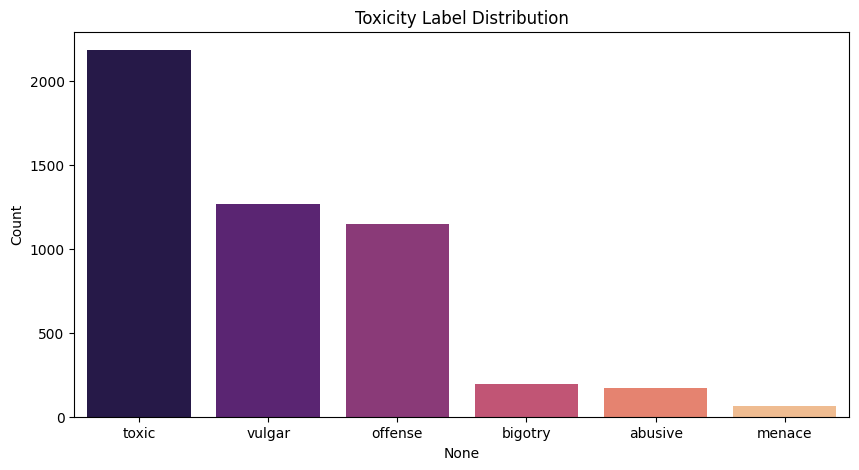

/tmp/ipykernel_160438/1892309529.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[w[0] for w in word_freq], y=[w[1] for w in word_freq], palette="viridis")


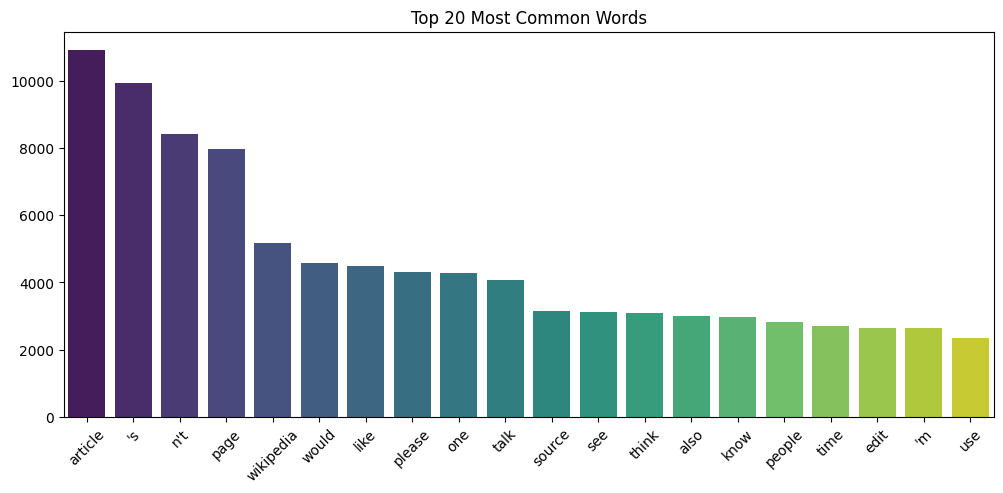

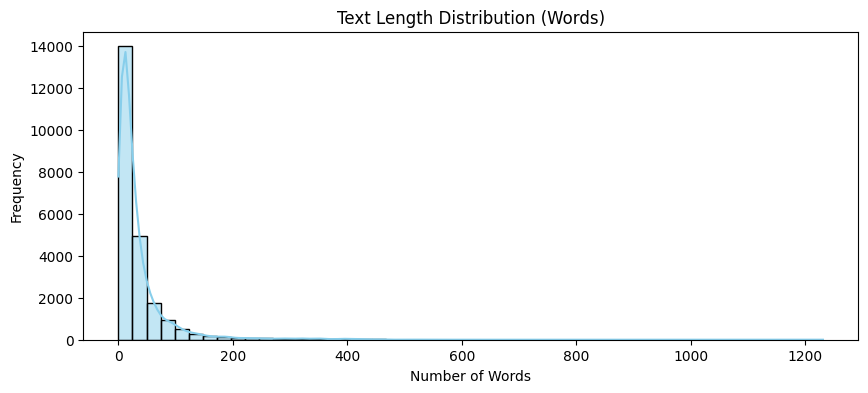


Missing Values:
id                 0
feedback_text      0
toxic              0
abusive            0
vulgar             0
menace             0
offense            0
bigotry            0
label_count        0
text_length        0
lang               0
alpha_ratio        0
is_punct           0
is_low_alpha       0
clean_text         0
translated_text    0
dtype: int64


In [32]:
from collections import Counter
from wordcloud import WordCloud

def run_eda(df):
    
    label_cols = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']
    label_sums = df[label_cols].sum().sort_values(ascending=False)

    plt.figure(figsize=(10,5))
    sns.barplot(x=label_sums.index, y=label_sums.values, palette='magma')
    plt.title("Toxicity Label Distribution")
    plt.ylabel("Count")
    plt.show()

    all_words = " ".join(df['clean_text']).split()
    word_freq = Counter(all_words).most_common(20)

    plt.figure(figsize=(12,5))
    sns.barplot(x=[w[0] for w in word_freq], y=[w[1] for w in word_freq], palette="viridis")
    plt.title("Top 20 Most Common Words")
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(10,4))
    sns.histplot(df['text_length'], bins=50, kde=True, color="skyblue")
    plt.title("Text Length Distribution (Words)")
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.show()
    
    print("\nMissing Values:")
    print(df.isnull().sum())

run_eda(train_df)

In [33]:
label_cols = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']

X_train = train_df['clean_text']
y_train = train_df[['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']]

In [34]:
train_df.head(2)

,id,feedback_text,toxic,abusive,vulgar,menace,offense,bigotry,label_count,text_length,lang,alpha_ratio,is_punct,is_low_alpha,clean_text,translated_text
0,281d77b7bebc2201,:::Sounds good. Let me know when you're done ...,0,0,0,0,0,0,0,9,en,0.705882,False,False,sound good let know 're done 'll start pr,sound good let know 're done 'll start pr
1,716aac7bf3c63db1,"""\nI say something, but it didn't actually con...",0,0,0,0,0,0,0,42,en,0.745763,False,False,say something n't actually confirm anything pu...,say something n't actually confirm anything pu...


In [35]:
X_train

0                sound good let know 're done 'll start pr
1        say something n't actually confirm anything pu...
2        agustina barrientos modelo piñeiro juán cruz a...
3        fyi enjoy licking stranger scrotal sacksespeci...
4        get site many penguin asked question simple go...
                               ...                        
23468                                       yo man pissing
23469                                             kid cunt
23470    think 's january suggestion mark moldovan lang...
23471    script character doogierussell spaghetti farts...
23472    whale mammal take people money spend mcdonadls...
Name: clean_text, Length: 23292, dtype: object

In [36]:
y_train

,toxic,abusive,vulgar,menace,offense,bigotry
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,1,0,1,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
23468,1,0,1,0,0,0
23469,1,0,1,0,0,0
23470,0,0,0,0,0,0
23471,0,0,0,0,0,0


- unsampling approach to handle imbalanced class 
- preventing the model for biased decision

In [37]:
from sklearn.utils import resample
import pandas as pd

df_train = pd.concat([X_train, y_train], axis=1)

df_majority = df_train[df_train['toxic'] == 0]
df_minority = df_train[df_train['toxic'] == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

X_train = df_upsampled['clean_text']
y_train = df_upsampled[label_cols]


- extracts the traslated test and toxic labels for validation dataset

In [38]:
X_val = validation_df['translated_text']

y_val = validation_df[['toxic']]
X_train.head(2)

0            sound good let know 're done 'll start pr
1    say something n't actually confirm anything pu...
Name: clean_text, dtype: object

### TfidfVectorizer:
- convert text data to numerical representation
- transform training data, test_data and validation data

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=30000, ngram_range=(1, 2))

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val) 
X_test_tfidf = vectorizer.transform(test_df['translated_text'])  


In [40]:
print(y_train.isnull().sum())


toxic      0
abusive    0
vulgar     0
menace     0
offense    0
bigotry    0
dtype: int64


- Train LR model in a multi label classification

In [41]:
from sklearn.linear_model import LogisticRegression

models = {}
for label in y_train.columns:
    model = LogisticRegression(max_iter=1000, class_weight='balanced')
    model.fit(X_train_tfidf, y_train[label])
    models[label] = model


- This loop find out the best threshold and store it


In [42]:
from sklearn.metrics import f1_score
import numpy as np

optimal_thresholds = {}
label = 'toxic'
probs = models[label].predict_proba(X_val_tfidf)[:, 1]
best_thresh, best_f1 = 0.5, 0
for thresh in np.arange(0.1, 0.9, 0.01):
    preds = (probs >= thresh).astype(int)
    f1 = f1_score(validation_df[label], preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh
optimal_thresholds[label] = best_thresh
print(f"{label}: Best threshold={best_thresh:.2f}, F1={best_f1:.4f}")



toxic: Best threshold=0.26, F1=0.2920


- Generating predictions for test_data set


In [43]:
predictions = {}
for label in models:
    probs = models[label].predict_proba(X_test_tfidf)[:, 1]
    threshold = optimal_thresholds.get(label, 0.5)
    predictions[label] = (probs >= threshold).astype(int)

pred_df = pd.DataFrame(predictions)
pred_df['id'] = test_df['id']


- Validating the predictions

In [44]:
from sklearn.metrics import classification_report

toxic_val_probs = models['toxic'].predict_proba(X_val_tfidf)[:, 1]
toxic_val_preds = (toxic_val_probs >= optimal_thresholds['toxic']).astype(int)

print(classification_report(validation_df['toxic'], toxic_val_preds))


              precision    recall  f1-score   support

           0       0.89      0.30      0.45       705
           1       0.18      0.80      0.29       134

    accuracy                           0.38       839
   macro avg       0.53      0.55      0.37       839
weighted avg       0.77      0.38      0.43       839



- applying the optimal threshold to predict test_data and saving the predictions

In [45]:
toxic_probs = models['toxic'].predict_proba(X_test_tfidf)[:, 1]

toxic_thresh = optimal_thresholds['toxic']
test_pred_toxic = (toxic_probs >= toxic_thresh).astype(int)

test_df['predicted_toxic'] = test_pred_toxic

print(test_df[['id', 'predicted_toxic']].head())

      id  predicted_toxic
0  56496                0
1  18266                0
2  37852                1
3  25075                0
4    330                0


In [46]:
test_df['predicted_toxic'].value_counts()

predicted_toxic
1    4863
0    1833
Name: count, dtype: int64

- Model Training: RandomForestClassifier is trained
- Threshold Optimization: find out the optimal threshold to find out the maximum F1 score
- Determination and Evaluation

In [47]:
from sklearn.ensemble import RandomForestClassifier
models = {}
for label in y_train.columns:
    model = RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced', 
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_tfidf, y_train[label])
    models[label] = model


In [48]:
from sklearn.metrics import f1_score
import numpy as np

label = 'toxic'
probs = models[label].predict_proba(X_val_tfidf)[:, 1]  

best_thresh, best_f1 = 0.5, 0

for thresh in np.arange(0.1, 0.9, 0.01):
    preds = (probs >= thresh).astype(int)  
    f1 = f1_score(validation_df[label], preds) 
    if f1 > best_f1: 
        best_f1 = f1
        best_thresh = thresh
optimal_thresholds = {label: best_thresh}

print(f"{label}: Best threshold={best_thresh:.2f}, F1={best_f1:.4f}")


toxic: Best threshold=0.10, F1=0.2780


In [49]:
from sklearn.metrics import classification_report

label = 'toxic'
probs = models[label].predict_proba(X_val_tfidf)[:, 1]
preds = (probs >= optimal_thresholds[label]).astype(int)

print("Validation Set Performance (Toxic):")
print(classification_report(validation_df[label], preds))


Validation Set Performance (Toxic):
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       705
           1       0.29      0.27      0.28       134

    accuracy                           0.78       839
   macro avg       0.58      0.57      0.57       839
weighted avg       0.77      0.78      0.77       839

